In [1]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
from scipy.linalg import expm

In [2]:
def solve_master(Hami,dm,decoop1,decoop2,decoop3,rate1,rate2,rate3):
    down1 = decoop1
    down2 = decoop2
    down3 = decoop3
    up1 = np.matrix(down1).getH()
    up2 = np.matrix(down2).getH()
    up3 = np.matrix(down3).getH()
    temp1 = (0-1j)*(np.dot(Hami, dm) - np.dot(dm, Hami))
    temp2 = 2*np.dot(np.dot(down1, dm), up1) - np.dot(np.dot(up1, down1), dm) -np.dot(np.dot(dm, up1), down1)
    temp3 = 2*np.dot(np.dot(down2, dm), up2) - np.dot(np.dot(up2, down2), dm) -np.dot(np.dot(dm, up2), down2)
    temp4 = 2*np.dot(np.dot(down3, dm), up3) - np.dot(np.dot(up3, down3), dm) -np.dot(np.dot(dm, up3), down3)
    out =  temp1 + (np.multiply(rate1, temp2) + np.multiply(rate2, temp3) + np.multiply(rate3, temp4))/2
    return out

In [3]:
class CliffordGate:
    def __init__(self):
        self.angles = [ (1.3e-5, 0, 0), 
                        (np.pi, np.pi/2, 0),
                        (np.pi, np.pi/2, np.pi/2), 
                        (np.pi, 0, 0),
                        (np.pi, np.pi*3/4, 0),
                        (np.pi, np.pi/4, 0),
                        (np.pi, np.pi/4, np.pi/2),
                        (np.pi, np.pi*3/4, np.pi/2), 
                        (np.pi, np.pi/2, np.pi/4),
                        (np.pi, np.pi/2, np.pi*3/4),
                        (np.pi/2, np.pi/2, 0),
                        (np.pi/2, np.pi/2, np.pi),
                        (np.pi/2, np.pi/2, np.pi/2),
                        (np.pi/2, np.pi/2, np.pi*3/2),
                        (np.pi/2, 0, 0),
                        (np.pi/2, np.pi, 0),
                        (np.pi*2/3, np.arccos(-1/np.sqrt(3)), np.pi/4),
                        (np.pi*2/3, np.arccos(1/np.sqrt(3)), -np.pi/4),
                        (np.pi*2/3, np.arccos(1/np.sqrt(3)), np.pi*3/4),
                        (np.pi*2/3, np.arccos(-1/np.sqrt(3)), np.pi*5/4),
                        (np.pi*2/3, np.arccos(1/np.sqrt(3)), np.pi/4),
                        (np.pi*2/3, np.arccos(-1/np.sqrt(3)), np.pi*3/4),
                        (np.pi*2/3, np.arccos(-1/np.sqrt(3)), -np.pi/4), 
                        (np.pi*2/3, np.arccos(1/np.sqrt(3)), np.pi*5/4)   ]
        
    def U_randtarget(self):
        # Generalize a random integer in the range of 1 to 24
        randnum = np.random.randint(low=1, high=8) # high will be 24 in the later version
        # Pick out the corresponding value of angles
        self.gamma = self.angles[randnum-1][0]
        self.theta = self.angles[randnum-1][1]
        self.phi = self.angles[randnum-1][2]        
        # Utarget1=[cos(ThetaA1) 0 sin(ThetaA1)*exp(-1i*Fei1);0 1 0;sin(ThetaA1)*exp(1i*Fei1) 0 -cos(ThetaA1)];
        # Factor  np.exp((0-1j)*(self.gamma/2))* omitted
        self.target = np.array([[np.cos(self.gamma/2)+(0+1j)*np.sin(self.gamma/2)*np.cos(self.theta), 0, (0-1j)*np.sin(self.gamma/2)*np.sin(self.theta)*np.exp((0-1j)*self.phi)],
                                                         [0, 1, 0],
                                                         [(0-1j)*np.sin(self.gamma/2)*np.sin(self.theta)*np.exp((0+1j)*self.phi), 0, np.cos(self.gamma/2)-(0+1j)*np.sin(self.gamma/2)*np.cos(self.theta)]])  

In [4]:
identy = np.identity(3)
zerostate = [[1], [0], [0]]
estate = [[0], [1], [0]]
onestate = [[0], [0], [1]]
Psi = np.identity(3)
# Define the operator
A0e = np.dot(zerostate, np.transpose(estate))
Ae0 = np.dot(estate, np.transpose(zerostate))
Ae1 = np.dot(estate, np.transpose(onestate))
A1e = np.dot(onestate, np.transpose(estate))
A00 = np.dot(zerostate, np.transpose(zerostate))
Aee = np.dot(estate, np.transpose(estate))
A11 = np.dot(onestate, np.transpose(onestate))
# Define the decay operator
Gamma0 = A0e+A1e
Gamma1 = 2*Aee-A00-A11
Gamma2 = np.zeros((3,3))
# Define the H values
omega00 = 2*np.pi*10
omega0 = omega00
# Time
T = 0.01;
tao = 2*T;
# Decay value
kappa0 = 2*np.pi*10/1000; # Cavity decay
kappa1 = 2*np.pi*10/1000; # Effective atom decay 16ns
kappa2 = 0;

In [5]:
m = 20
U_target = np.identity(3)
Ug = CliffordGate()
phi = np.zeros(m)
theta = np.zeros(m)
for i in range(1, m+1, 1):
    Ug.U_randtarget()
    phi[i-1] = Ug.phi
    theta[i-1] = Ug.theta
    U_target = np.matmul(Ug.target, U_target)    

In [6]:
# Initial states
intialstate = zerostate
initialdm = np.matmul(intialstate, np.matrix(intialstate).getH())
dm1 = initialdm
finalatomstate1 = zerostate
fidm1 = np.matmul(finalatomstate1, np.matrix(finalatomstate1).getH())
finalatomstate2 = estate
fidm2 = np.matmul(finalatomstate2, np.matrix(finalatomstate2).getH())
finalatomstate3 = onestate
fidm3 = np.matmul(finalatomstate3, np.matrix(finalatomstate3).getH())
finalatomstate4 = np.matmul(U_target, intialstate)
fidm4 = np.matmul(finalatomstate4, np.matrix(finalatomstate4).getH())
# Max Rabi frequency
# Dots drawn per period每一个周期画的点数
dotsPerPeriod = 1000;
numberOfPeriod = 1;
# Define time and setp
U = np.identity(3)
# Define time and setp
timestep = tao/dotsPerPeriod;  # Draw dotsPerPeriod dots per period
time = m*numberOfPeriod*dotsPerPeriod;  # Draw numberOfPeriod periods

In [7]:
# Record all states in 10000 states
f0 = np.zeros(time)
f1 = np.zeros(time)
f2 = np.zeros(time)
f3 = np.zeros(time)
for n in range(1, time+1, 1):
    t = (n-1)*timestep
    PHI = phi[0]*((0<=t)&(t<=tao))+phi[1]*((tao<t)&(t<=2*tao))+phi[2]*((2*tao<=t)&(t<=3*tao))+phi[3]*((3*tao<t)&(t<=4*tao))+phi[4]*((4*tao<=t)&(t<=5*tao))+phi[5]*((5*tao<t)&(t<=6*tao))+phi[6]*((6*tao<=t)&(t<=7*tao))+phi[7]*((7*tao<t)&(t<=8*tao))+phi[8]*((8*tao<t)&(t<=9*tao))+phi[9]*((9*tao<t)&(t<=10*tao))+phi[10]*((10*tao<=t)&(t<=11*tao))+phi[11]*((11*tao<t)&(t<=12*tao))+phi[12]*((12*tao<=t)&(t<=13*tao))+phi[13]*((13*tao<t)&(t<=14*tao))+phi[14]*((14*tao<=t)&(t<=15*tao))+phi[15]*((15*tao<t)&(t<=16*tao))+phi[16]*((16*tao<=t)&(t<=17*tao))+phi[17]*((17*tao<t)&(t<=18*tao))+phi[18]*((18*tao<t)&(t<=19*tao))+phi[19]*((19*tao<t)&(t<=20*tao))
    THETA = theta[0]*((0<=t)&(t<=tao))+theta[1]*((tao<t)&(t<=2*tao))+theta[2]*((2*tao<=t)&(t<=3*tao))+theta[3]*((3*tao<t)&(t<=4*tao))+theta[4]*((4*tao<=t)&(t<=5*tao))+theta[5]*((5*tao<t)&(t<=6*tao))+theta[6]*((6*tao<=t)&(t<=7*tao))+theta[7]*((7*tao<t)&(t<=8*tao))+theta[8]*((8*tao<t)&(t<=9*tao))+theta[9]*((9*tao<t)&(t<=10*tao))+theta[10]*((10*tao<=t)&(t<=11*tao))+theta[11]*((11*tao<t)&(t<=12*tao))+theta[12]*((12*tao<=t)&(t<=13*tao))+theta[13]*((13*tao<t)&(t<=14*tao))+theta[14]*((14*tao<=t)&(t<=15*tao))+theta[15]*((15*tao<t)&(t<=16*tao))+theta[16]*((16*tao<=t)&(t<=17*tao))+theta[17]*((17*tao<t)&(t<=18*tao))+theta[18]*((18*tao<t)&(t<=19*tao))+theta[19]*((19*tao<t)&(t<=20*tao))
    OmegaR = np.pi*2/tao
    OmegaP = np.sin(THETA/2)*OmegaR*1.0
    OmegaS = -np.cos(THETA/2)*OmegaR*np.exp((0+1j)*PHI)
    Hamiltonian1 = (OmegaP*A0e+np.conj(OmegaP)*Ae0+OmegaS*A1e+np.conj(OmegaS)*Ae1)/2
    dt = timestep;
    U = np.matmul(expm((0-1j)*Hamiltonian1*dt), U)
    Psi = np.matmul(expm((0-1j)*Hamiltonian1*dt), Psi)
    k1 = solve_master(Hamiltonian1,dm1,Gamma0,Gamma1,Gamma2,kappa0,kappa1,kappa2);
    k2 = solve_master(Hamiltonian1,dm1+0.5*timestep*k1,Gamma0,Gamma1,Gamma2,kappa0,kappa1,kappa2);
    k3 = solve_master(Hamiltonian1,dm1+0.5*timestep*k2,Gamma0,Gamma1,Gamma2,kappa0,kappa1,kappa2);
    k4 = solve_master(Hamiltonian1,dm1+timestep*k3,Gamma0,Gamma1,Gamma2,kappa0,kappa1,kappa2);
    dm1 = dm1+(timestep/6)*(k1+2*k2+2*k3+k4);
    dm1 = 0.5*(dm1+np.matrix(dm1).getH());
    dm1 = dm1/(np.trace(dm1));
    rho = dm1;
    f0[n-1] = np.real(np.trace(np.matmul(rho, fidm1)))
    f1[n-1] = np.real(np.trace(np.matmul(rho, fidm2)))
    f2[n-1] = np.real(np.trace(np.matmul(rho, fidm3)))
    f3[n-1] = np.real(np.trace(np.matmul(rho, fidm4)))

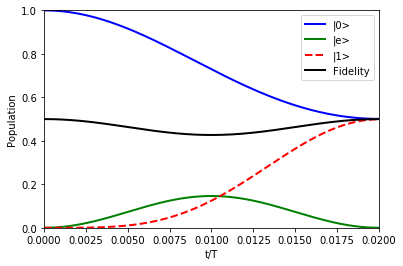

In [8]:
n = np.arange(1, time+1)
v = 1*n/dotsPerPeriod*tao
plt.plot(v, f0, color='b', linewidth=2, label='|0>')
plt.plot(v, f1, color='g', linewidth=2, label='|e>')
plt.plot(v, f2, color='r', linestyle='dashed', linewidth=2, label='|1>')
plt.plot(v, f3, color='k', linewidth=2, label='Fidelity')
plt.axis([0.0, 0.02, 0, 1])
plt.xlabel('t/T')
plt.ylabel('Population')
plt.legend(loc="upper right", frameon=True)
#set(gca,'FontSize',14)
plt.show()

In [9]:
f0

array([0.99999855, 0.99999422, 0.99998699, ..., 0.48701011, 0.48702173,
       0.48702873])